# Spatial Normalization

When doing neuroimaging research, we want to compare brain tissue properties between groups of people. This could be between between healthy individuals and patients to further understand disease, or younger and older people to understand ageing's affect on the brain.

But how can we compare brains when each brain is shaped slightly differently and people's heads may be positioned differently in the scanner? We need to overlap the images we have to make these comparisons (think standing back to back with someone to compare height, or overlapping hands to compare hand size). 

**Spatial normalisation** allows us to combine brain images across modalities, individuals and studies. This involves moving images into a common 'space' using registration algorithms (see earlier episode).

## We need the following for spatial normalisation

1. A reference frame: A 3D space that assigns x,y,z coordinates to anatomical regions (independent of voxel dimensions!).

2. A common template: a single or an average image volume as an alignment target

3. An image registration algorithm


<img src=../fig/Subject_vs_common_space.png alt="Drawing" align="middle" width="1000px"/>



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import datasets
from nilearn import plotting
from nibabel.affines import apply_affine

## Dataset

We will be using some data from the last episode:

[AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI Collection from [OpenNeuro](https://openneuro.org/datasets/ds002790/versions/2.0.0).

We have already downloaded data for 'sub-0001' or 'sub-0002' in the local_data/AOMIC directory. 

## Local paths

In [12]:
local_data_dir = '../data/'

freesurfer_output_dir = local_data_dir + 'AOMIC/derivatives/freesurfer/sub-0001/mri/'
fsaverage_dir = local_data_dir +  'AOMIC/derivatives/freesurfer/fsaverage5/mri/'

# 1. Reference Frame

So far we have worked with image data that has 3 dimensions (think `x,y,z` output from a `T1_image.shape` command).

But this doesn't provide any information for how it relates to a person's anatomy (i.e. towards the front or back of the brain). Additionally, the size of voxels can differ between scans and the orientation of scans can differ for the same person.

For example, let's look the two scans below for the same person. An EPI scan (red) and structural T1w scan (blue). The boxes represent the size (also called field of view (FOV)) and orientation of the images. The EPI and T1w image have different sizes, orientations and centre points (origins). How can we relate the data in each scan to the same anatomical locations?

<img src="https://nipy.org/nibabel/_images/localizer.png" alt="Drawing" align="middle" width="750px"/>

This is where a **reference frame** comes in. This relates the voxel coordinates `x,y,z` to a coordinate system as someone lays in the scanner `left/right, back/front, down/up`. This can tell us where in the brain each voxel is with respect to the person (e.g. 4mm from the centre towards the front of the brain).


## The Affine

This takes us back to the affine property in the image header discussed in the morning session.

The image affine is a mathematical operation that describes how to move from the voxel coordinate system to the anatomical coordinate system.

Moving from one space to another involves rotations (spinning), scaling, shearing (stretching/squeezing) and translations (shifting). The affine describes these properties and provides a mapping between voxel and anatomical reference coordinate systems.

In [13]:
# set decimal place to 3 for pretty output
np.set_printoptions(precision=3, suppress=True)

# load an image
T1_image = nib.load('../data/AOMIC/sub-0001/anat/sub-0001_T1w.nii.gz')

# print the affine
print(T1_image.affine)

[[  -1.       0.01    -0.028  121.292]
 [   0.009    0.999    0.037 -116.74 ]
 [  -0.028   -0.037    0.999  -62.331]
 [   0.       0.       0.       1.   ]]


The first 3 x 3 block of the affine describes rotations, scalings and shearings needed to move to the reference space. We can extract this using indexing.

In [14]:
print(T1_image.affine[0:3, 0:3])

[[-1.     0.01  -0.028]
 [ 0.009  0.999  0.037]
 [-0.028 -0.037  0.999]]


The last column of the affine describes translations needed to move to the reference space

In [15]:
T1_image.affine[0:3, 3]

array([ 121.292, -116.74 ,  -62.331])

Can you extract the last row of the affine using indexing?

Solution

In [16]:
T1_image.affine[-1,:]

array([0., 0., 0., 1.])

The last row `[0 0 0 1]` is a mathematical trick that allows us to do rotations, scalings, shearings and translations all in one go. Otherwise we would need to do translations separately.

Many neuroimaging software packages read and make use of the affine automatically, so you will rarely need to do these calculations from scratch. However, understanding these coordinate systems is important to understand later concepts of spatial normalisation and can help solve problems if your images aren't lining up!

To learn more about these coordinate systems, we would recommend looking at the [nibabel](https://nipy.org/nibabel/coordinate_systems.html) site.

## 2. Common Templates

In order to compare brain properties of many different people, we need a *common reference frame*. This is where **templates** are useful.

The allows researchers to align many MRI scans from different people in a study and compare corresponding anatomical areas in an analysis.

A good template should be a representative average of the study cohort. However, creating a template is computationally intensive so image processing pipelines typically use publicly available templates. This also allows for results to be comparative across studies.

Because templates are an average of many brains, they often appear more blurry than individual scans. We still use the information from the original MRI scans, but use the template as a common space to do our analysis.


- Commonly used templates:
    - [MNI 305](https://ieeexplore.ieee.org/document/373602)
        - an average of 305 T1-weighted MRI scans from young healthy adults
        - 305 normal MRI brains were linearly coregistered (9-param) to 241 brains that had been coregistered (roughly) to the Talairach atlas. 
    - [Collin27](https://journals.lww.com/jcat/Abstract/1998/03000/Enhancement_of_MR_Images_Using_Registration_for.32.aspx)
        - One individual scanned 27 times and the images linearly registered to create an average with high SNR and structure definition 
        - Linearly registered to the MNI 305
    - [MNI152 linear a.k.a. ICBM152](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1088516/) (International Consortium for Brain Mapping) 
        - An average of 152 T1-weighted MRI scans from young adults
        - Linearly coregistered (9-param) to the MNI 305
        - Higher resolution and better contrast than the MNI305
        - Used by SPM
    - [MNI152 nonlinear](https://link.springer.com/chapter/10.1007%2F11866763_8)
        - Version of MNI152 nonlinearly registered to MNI 305 
        - Updated versions
            - MNI152NLin6Asym: used by FSL
            - MNI152NLin2009cAsym: used by fMRIprep
    - [fsaverage](https://pubmed.ncbi.nlm.nih.gov/10619420/)
        - _Surface template_ characterized by "vertices and faces/triangles" 
        - Spherical alignment of 40 participants 
        - 163,842 vertices per hemispheres

### T1 templates (MNI305, Collin27, MNI152 (linear), MNI152 (nonlinear))
![MNI_spaces](../fig/MNI_spaces_caption.jpeg)


## Subject (native) space vs template (reference) space 

### Question: Do the x,y,z coordinates for "subject space" vs. "template space" map to the same location in the brain? 

### FreeSurfer example

Lets look at an individual's T1 image and the FreeSurfer template

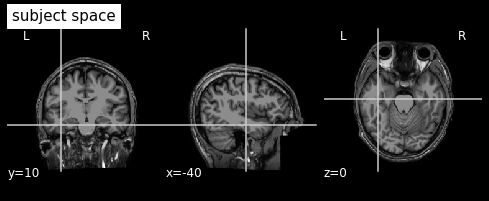

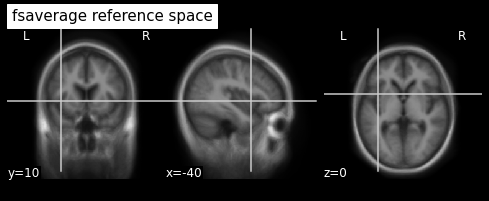

In [18]:
# these are the coordinates we'd like to centre our cross-hair on in each image
cut_coords = (-40,10,0)

# subject image (native space)
subject_T1 = freesurfer_output_dir + 'T1.mgz'

# fsaverage image (reference space)
fsaverage_T1 = fsaverage_dir + "T1.mgz"

# native (individual's) scan plot
plotting.plot_anat(subject_T1, title="subject space", cut_coords=cut_coords, vmax=200)

# template plot
plotting.plot_anat(fsaverage_T1, title="fsaverage reference space", cut_coords=cut_coords, vmax=200)

Do the coordinates`[-40,10,0]` correpond to the same anatomical location in the subject and reference space? 

So how do we get the mapping between native space and the reference space?

**Registration algorithms!**

## 3. Image Registration Algorithms

Registration is process that aligns an image from one coordinate space to another. Think again on aligning your hands to compare their size. Our brains can calculate how align our hands automatically but computers need to calculate this explicitly. It also gets very complex when considering the complicated morphology of the human brain!

- **What is Registration for?**
    - building templates 
    - native (subject) space to template-space alignment (normalization)
    - inter-subject alignment (typically for cohort specific)
    - intra-subject alignment (co-registration of image modalities or longitudinal analyses)

<br>

- **Types of Registration Algorithms (Transforms)**
    - Linear: global feature aligment
        - Rigid (6 parameters): rotation, translation 
        - Affine (12 parameters): rotation, translation, scaling, skewing  
    - Nonlinear (a.k.a elastic): local feature aligment via warping
        - Computationally intensive deformation models with large number of parameters
        - Employ diffeomorphic models that preserve topology and source-target symmetry

_Note: Linear registrations are often used as an initialization step for non-linear registration._ 


- Rigid registration example (_source: [SimpleITK](https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks)_): 
    - The figure below shows the source image being registered to the target (left) in an iterative process. The optimized loss is shown on the right. 

![rigid_process](../fig/registration_visualization_itk.gif)



- Nonlinear deformation example _(source: 3D Slicer [publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3466397/), [wiki](https://www.slicer.org/wiki/Documentation:Nightly:Registration:RegistrationLibrary:RegLib_C42))_
    - The figure below shows local deformation (i.e. warping) of source image due to nonlinear registration. 

![nonlinear_deform_process](../fig/Silcer_DeformOnly.gif)

## How do we map a point-location (cross-hairs) from subject space to the reference space? 

A central part of many neuroimaging software packages is registration between the subject's native space and a template. 

This means the transformation is often already available. We can use the affine transform from the registration to find the corresponding anatomical location from native to reference space (for freesurfer: 'sub-0001/mri/transforms/talairach.xfm')

Let's see what's in that file:

In [24]:
%%bash
cat ../data/AOMIC/derivatives/freesurfer/sub-0001/mri/transforms/talairach.xfm

MNI Transform File
% avi2talxfm

Transform_Type = Linear;
Linear_Transform = 
1.027387 -0.011288 0.022386 -0.672699
-0.013200 1.032273 0.177898 -29.044456
-0.052202 -0.149410 1.149998 -22.219437;


Recognise the affine transformation? A 3x3 grid describing the rotation, scaling and skewing with a final column describing the translation. This is how sub-0001's T1 image moves from native space to the FreeSurfer reference space.

Lets create a numpy array of this affine transform (with our handy mathematical trick of `[0 0 0 1]` at the bottom).

We'll call this `A` for affine.

In [20]:
A = np.array([[1.027387, -0.011288, 0.022386, -0.672699],
              [-0.013200, 1.032273, 0.177898, -29.044456],
              [-0.052202, -0.149410, 1.149998, -22.219437],
              [0. ,0. , 0., 1.]])

Now we need to apply the affine to our previous `cut_coords` to see their corresponding location in the reference space. 

This is done using *matrix multiplication*. A nibabel function called `apply_affine` can do this for us. See the [nibabel](https://nipy.org/nibabel/coordinate_systems.html) documentation for how this works.

In [27]:
# apply the affine (A) to our cut_coords
cut_coords_affine_transformed = apply_affine(A, cut_coords)

# get the coordinates into a nice format to print
cut_coords_affine_transformed_print = tuple(cut_coords_affine_transformed.round().astype(int))

# look at native space coordinates and corresponding reference space coordinates
print('Subject space to reference space mapping: \n' + 
      str(cut_coords) +  ' --> ' + str(cut_coords_affine_transformed_print))

Subject space to reference space mapping: 
(-40, 10, 0) --> (-42, -18, -22)


Do these two coordinates now correspond to the same anatomical location?

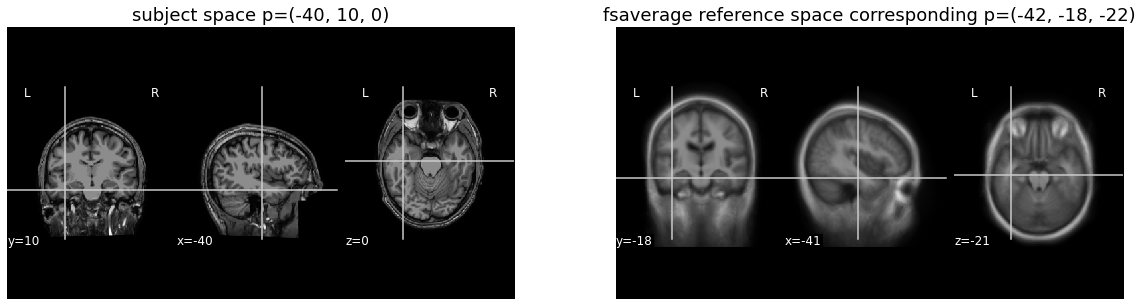

In [29]:
# plot
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))

ax=axes[0]
plotting.plot_anat(subject_T1, title="", cut_coords=cut_coords, vmax=200, axes=ax)
ax.set_title('subject space p={}'.format(cut_coords), fontsize=18)

ax=axes[1]
plotting.plot_anat(fsaverage_T1, title="", cut_coords=cut_coords_affine_transformed, vmax=200, axes=ax)
ax.set_title('fsaverage reference space corresponding p={}'.format(cut_coords_affine_transformed_print), fontsize=18);

Do you think the cross-hairs correspond to the same brain location in native and reference space?

### Challenge

Repeat the above and apply the affine transformation to the coordinate `(-10,5,20)` in native space. Visualise if they correspond to the same location in both the native and reference spaces.

Solution

Subject space to reference space mapping: 
(-10, 5, 20) --> (-11, -20, 1)


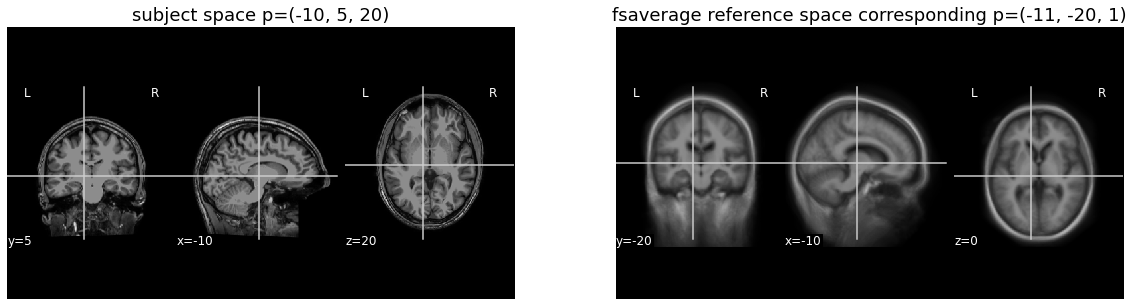

In [30]:
cut_coords = (-10,5,20)

# apply the affine (A) to our cut_coords
cut_coords_affine_transformed = apply_affine(A, cut_coords)

# get the coordinates into a nice format to print
cut_coords_affine_transformed_print = tuple(cut_coords_affine_transformed.round().astype(int))

# look at native space coordinates and corresponding reference space coordinates
print('Subject space to reference space mapping: \n' + 
      str(cut_coords) +  ' --> ' + str(cut_coords_affine_transformed_print))

# plot
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))

ax=axes[0]
plotting.plot_anat(subject_T1, title="", cut_coords=cut_coords, vmax=200, axes=ax)
ax.set_title('subject space p={}'.format(cut_coords), fontsize=18)

ax=axes[1]
plotting.plot_anat(fsaverage_T1, title="", cut_coords=cut_coords_affine_transformed, vmax=200, axes=ax)
ax.set_title('fsaverage reference space corresponding p={}'.format(cut_coords_affine_transformed_print), fontsize=18);